In [1]:
import agrovision_core
print('OK:', agrovision_core.__file__)

OK: D:\trying\AgroVision\agrovision_core\src\agrovision_core\__init__.py


# AgriFieldNet Data Pipeline

This notebook downloads and prepares the **AgriFieldNet India Challenge** dataset for crop classification using TorchGeo.

## Dataset Overview

| Property | Value |
|----------|-------|
| **Source** | Sentinel-2 satellite imagery |
| **Resolution** | 10m (visible/NIR), 20m (red edge/SWIR) |
| **Tile Size** | 256 × 256 pixels |
| **Total Tiles** | 1,217 tiles |
| **Training Fields** | 5,551 fields |
| **Test Fields** | 1,530 fields |
| **Crop Classes** | 13 classes |

### Crop Classes

| ID | Crop (English) | Crop (Arabic) |
|----|----------------|---------------|
| 1 | Wheat | قمح |
| 2 | Mustard | خردل |
| 3 | Lentil | عدس |
| 4 | No Crop / Fallow | بور |
| 5 | Green Pea | بسلة خضراء |
| 6 | Sugarcane | قصب السكر |
| 8 | Garlic | ثوم |
| 9 | Maize | ذرة صفراء |
| 13 | Gram / Chickpea | حمص |
| 14 | Coriander | كزبرة |
| 15 | Potato | بطاطس |
| 16 | Berseem | برسيم |
| 36 | Rice | أرز |

In [5]:
from pathlib import Path
import os

parent = Path.cwd().parent
os.chdir(parent)
print(f"Changed working directory to parent: {Path.cwd()}")

Changed working directory to parent: d:\trying\AgroVision


## 1. Import Libraries

We use **TorchGeo**, a PyTorch library specifically designed for geospatial deep learning.

- **`AgriFieldNet`**: The dataset class that handles loading Sentinel-2 imagery and crop labels
- **`AgriFieldNetDataModule`**: A PyTorch Lightning DataModule that wraps the dataset with DataLoaders, samplers, and train/val/test splits

TorchGeo abstracts away the complexity of:
- Coordinate reference systems (CRS)
- Geospatial file formats (GeoTIFF)
- Multi-resolution band alignment
- Spatial sampling strategies

In [6]:
from torchgeo.datasets import AgriFieldNet
from torchgeo.datamodules import AgriFieldNetDataModule

## 2. Setup Data Directory

Create the local directory where the dataset will be stored. The dataset requires approximately **2-3 GB** of disk space.

```
data/
└── agrifieldnet/
    ├── source/           # Sentinel-2 bands (B01-B12)
    ├── train_labels/     # Crop type labels + field IDs
    └── test_labels/      # Test set field IDs
```

In [7]:
# Create data directory if it doesn't exist
os.makedirs("data/agrifieldnet", exist_ok=True)

## 3. Download the Dataset

This cell downloads the AgriFieldNet dataset from **Source Cooperative** using `azcopy`.

### What gets downloaded:

| Component | Description | Size |
|-----------|-------------|------|
| **Source imagery** | 12 Sentinel-2 spectral bands per tile | ~2 GB |
| **Train labels** | `raster_labels.tif` (crop classes) + `field_ids.tif` | ~500 MB |
| **Test labels** | `field_ids.tif` only (no crop labels) | ~200 MB |

### Sentinel-2 Bands Included:

| Band | Name | Wavelength | Resolution | Purpose |
|------|------|------------|------------|---------|
| B01 | Coastal Aerosol | 443 nm | 60m | Atmospheric correction |
| B02 | Blue | 490 nm | 10m | Water, vegetation |
| B03 | Green | 560 nm | 10m | Vegetation health |
| B04 | Red | 665 nm | 10m | Chlorophyll absorption |
| B05 | Red Edge 1 | 705 nm | 20m | Vegetation stress |
| B06 | Red Edge 2 | 740 nm | 20m | Leaf area index |
| B07 | Red Edge 3 | 783 nm | 20m | Canopy structure |
| B08 | NIR | 842 nm | 10m | Biomass (NDVI) |
| B8A | NIR Narrow | 865 nm | 20m | Water vapor |
| B09 | Water Vapor | 945 nm | 60m | Atmospheric |
| B11 | SWIR 1 | 1610 nm | 20m | Moisture content |
| B12 | SWIR 2 | 2190 nm | 20m | Mineral/dry vegetation |

> **Note**: Download time varies from 10-30 minutes depending on internet speed.

In [8]:
# Download the dataset (this will use azcopy)
# This may take a while depending on your internet connection

dataset = AgriFieldNet(
    paths="data/agrifieldnet",
    download=True,  # This triggers the download
)

## 4. Verify the Dataset

After download, we verify the dataset loaded correctly by checking:

- **CRS (Coordinate Reference System)**: The geographic projection used (typically EPSG:32643 - UTM Zone 43N for India)
- **Bands**: List of available spectral bands
- **Files**: Number of GeoTIFF files indexed by TorchGeo

### Expected Output:
```
Dataset CRS: EPSG:32643
Dataset bands: ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12')
Number of files: 1217
```

In [9]:
# Verify the dataset
print(f"Dataset CRS: {dataset.crs}")
print(f"Dataset bands: {dataset.bands}")
print(f"Number of files: {len(dataset.files)}")

Dataset CRS: PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32645"]]
Dataset bands: ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12')
Number of files: 1217


In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from torchgeo.datasets import AgriFieldNet
from torchgeo.samplers import RandomGeoSampler

# -----------------------------
# 1) Dataset root + download
# -----------------------------
root = "data/agrifieldnet"

# Only load RGB bands (Sentinel-2: B04=R, B03=G, B02=B) for easy visualization
dataset = AgriFieldNet(
    paths=root,
    bands=AgriFieldNet.rgb_bands,  # ('B04','B03','B02')
    download=False,                 # set False if you already downloaded it
)


In [51]:
# -----------------------------
# 2) Random sample (chip)
# -----------------------------
# size is in PIXELS by default; 256 gives a 256x256 sample. :contentReference[oaicite:2]{index=2}
sampler = RandomGeoSampler(dataset, size=256, length=1)
query = next(iter(sampler))      # a BoundingBox
sample = dataset[query]          # dict with keys like: 'image', 'mask', 'crs', 'bounds'

image = sample["image"]          # Tensor [C,H,W], C=3 here
mask = sample["mask"].squeeze()  # Tensor [H,W] (ordinal class indices)

In [52]:
# -----------------------------
# 3) Human-readable class names
# -----------------------------
# AgriFieldNet original class codes -> names (from the dataset docstring) :contentReference[oaicite:3]{index=3}
CODE_TO_NAME = {
    0: "No-Data",
    1: "Wheat",
    2: "Mustard",
    3: "Lentil",
    4: "No Crop/Fallow",
    5: "Green pea",
    6: "Sugarcane",
    8: "Garlic",
    9: "Maize",
    13: "Gram",
    14: "Coriander",
    15: "Potato",
    16: "Berseem",
    36: "Rice",
}

# TorchGeo maps original codes -> ordinal indices internally (0..N-1).
# With default 'classes', ordinal index i corresponds to this original code:
ordinal_to_code = list(AgriFieldNet.cmap.keys())  # insertion order used by TorchGeo

uniq, counts = torch.unique(mask, return_counts=True)
present = [(int(u), int(c)) for u, c in zip(uniq, counts) if int(u) != 0]

print("Random query bounds:", query)
if not present:
    print("Classes present: (only background / unlabeled pixels)")
else:
    print("Classes present in this sample:")
    for u, c in sorted(present, key=lambda t: -t[1]):
        code = ordinal_to_code[u] if u < len(ordinal_to_code) else None
        name = CODE_TO_NAME.get(code, f"code={code}")
        print(f"  ordinal={u:2d}  original_code={code:>2}  name={name:<15}  pixels={c}")


Random query bounds: (slice(-550272.4555098587, -547712.4555098587, None), slice(2809252.6289865323, 2811812.6289865323, None), slice(Timestamp('1677-09-21 00:12:43.145224193'), Timestamp('2262-04-11 23:47:16.854775807'), None))
Classes present in this sample:
  ordinal= 2  original_code= 2  name=Mustard          pixels=182


## Explanation of the output

### Random query bounds

```
(slice(-64981.6, -62421.6),
 slice(3105657.8, 3108217.8),
 slice(1677-09-21, 2262-04-11))
```

* This is the **spatial bounding box** of the randomly sampled tile.
* First slice → **X coordinate range**
* Second slice → **Y coordinate range**
* Third slice → **time range** (not relevant here; dataset is static)
* Together, they define **where the 256×256 tile was sampled from**.

### Classes present in this sample

```
ordinal=2  original_code=2  name=Mustard  pixels=53
```

* The sampled tile contains **only one crop class**.
* `ordinal` → internal TorchGeo class index
* `original_code` → original dataset label value
* `pixels` → number of pixels belonging to that class in the tile

### Interpretation

* The tile is **mostly background or unlabeled**
* Only **53 pixels** correspond to the crop **Mustard**
* This is expected when using **random spatial sampling**


In [53]:
# -----------------------------
# 4) Prepare RGB + mask colors
# -----------------------------
# Normalize RGB for display (min-max)
img = image.permute(1, 2, 0).detach().cpu().numpy().astype(np.float32)
img = (img - img.min()) / (img.max() - img.min() + 1e-6)

# Colorize mask using TorchGeo's internal ordinal colormap (RGBA uint8)
mask_np = mask.detach().cpu().numpy().astype(np.int64)
cmap = dataset.ordinal_cmap.detach().cpu().numpy()           # [num_classes, 4]
mask_rgba = cmap[mask_np]                                    # [H,W,4], uint8

# Build overlay: show mask only where mask > 0
alpha = 0.50
overlay = img.copy()
mask_rgb = mask_rgba[..., :3].astype(np.float32) / 255.0
m = (mask_np > 0)[..., None]
overlay[m[..., 0]] = (1 - alpha) * img[m[..., 0]] + alpha * mask_rgb[m[..., 0]]


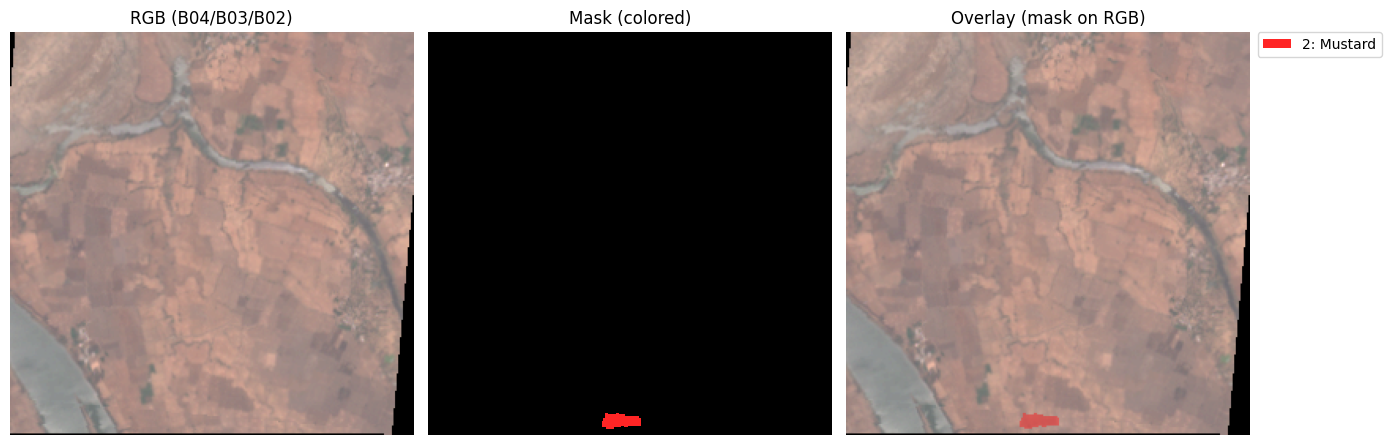

In [54]:

# -----------------------------
# 5) Plot: RGB, Mask, Overlay
# -----------------------------
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

axs[0].imshow(img)
axs[0].set_title("RGB (B04/B03/B02)")
axs[0].axis("off")

axs[1].imshow(mask_rgba, interpolation="nearest")
axs[1].set_title("Mask (colored)")
axs[1].axis("off")

axs[2].imshow(overlay)
axs[2].set_title("Overlay (mask on RGB)")
axs[2].axis("off")

# Optional: legend for classes present (non-background)
if present:
    handles = []
    for u, _ in sorted(present, key=lambda t: t[0]):
        code = ordinal_to_code[u] if u < len(ordinal_to_code) else None
        name = CODE_TO_NAME.get(code, f"code={code}")
        color = (cmap[u, :3] / 255.0).tolist()
        handles.append(Patch(facecolor=color, edgecolor="none", label=f"{u}: {name}"))
    axs[2].legend(handles=handles, loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0)

plt.tight_layout()
plt.show()
